In [2]:
import json

import pandas as pd
import seaborn as sns
from pathlib2 import Path
from collections import defaultdict, OrderedDict

from vocab import Language, HelpDeskType
from data import parse_labels

In [3]:
def read_raw_data(data_dir, lang):
    if lang == Language.chinese:
        with open(data_dir / "train_data_cn.json", 'r', encoding="utf-8") as train_fp:
            train_json = json.load(train_fp)
        with open(data_dir / "test_data_cn.json", 'r', encoding="utf-8") as test_fp:
            test_json = json.load(test_fp)
        return train_json, test_json

In [ ]:
def save_categorized_raw_data(json):
    CZ_json = []
    DX_json = []
    LT_json = []
    OT_json = []
    
    for dialogue in json:
        is_categorized = False
        for turn in dialogue["turns"]:
            for utterance in turn["utterances"]:
                tokens = utterance.split()
                for token in tokens:
                    if token.startswith('@'):
                        if HelpDeskType.CZ.value in token:
                            return "C"
                        elif HelpDeskType.LT.value in token:
                            return "L"
                        elif HelpDeskType.DX.value in token:
                            return "D"
                        else:
                            continue
    
        

In [61]:
def process_raw_data(raw_data, is_train):    
    def data_gen():
        for dialogue in raw_data:
            senders = []
            texts = []
            for turn in dialogue["turns"]:
                sender = 1 if turn["sender"].startswith("c") else 0
                senders.append(sender)
                text = " ".join(turn["utterances"])
                texts.append(text)
                
            if is_train:
                customer_nugget_label, helpdesk_nugget_label, quality_label = \
                    parse_labels(dialogue["annotations"], senders)
                yield (dialogue["id"],
                       senders,
                       texts,
                       customer_nugget_label,
                       helpdesk_nugget_label,
                       quality_label)

            else:
                yield (dialogue["id"],
                       senders,
                       texts)
    data = [x for x in data_gen()]
    return data

In [4]:
data_dir = Path("stc3dataset/data")
lang = Language.chinese
raw_train, raw_test = read_raw_data(data_dir, lang)

In [62]:
data_train = process_raw_data(raw_train, True)
data_test = process_raw_data(raw_test, False)

In [6]:
# No "PAD" nuggets?
for dialogue in data_train:
    for c_label in dialogue[3]:
        if c_label[0] != 0:
            print("Found")
    for h_label in dialogue[4]:
        if h_label[0] != 0:
            print("Found")

In [48]:
data_train[0]

('3830401296796826',
 [1, 0],
 ['中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服',
  '您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]；'],
 [array([0.        , 0.7368421 , 0.05263158, 0.        , 0.21052632],
        dtype=float32)],
 [array([0.        , 0.47368422, 0.        , 0.5263158 ], dtype=float32)],
 array([[0.        , 0.05263158, 0.6315789 , 0.21052632, 0.10526316],
        [0.        , 0.15789473, 0.57894737, 0.05263158, 0.21052632],
        [0.        , 0.        , 0.7368421 , 0.        , 0.2631579 ]],
       dtype=float32))

In [93]:
data_test[1]

('4121001149457182',
 [1, 0, 1, 0, 1, 0, 1],
 ['距离我反映问题已经一个星期了,你们@花粉助手小D @荣耀honor @荣耀手机 @华为终端官方微博 好有耐心哦 \u200b',
  '您好,建议您先确认手机系统版本是否最新,如果有提示升级,建议备份升到最新版本,如果版本已经最新,建议备份好数据送修网点检测处理.',
  '很遗憾的告诉您：网店表示也解决不了,又把皮球踢给你们了',
  '亲,您去过售后了吗',
  '是的',
  '您好,您的心情小D非常理解,请您放心小D会尽我所能的帮您解决问题,烦请您私信留下您的联系方式和去过的售后网点的具体地址、版本号、IMEI号,小编会进行记录并反馈,尽快解决.',
  '不是已经给过了吗？怎么还要？'])

In [8]:
at_tags_dict = defaultdict(list)
for dialogue in data_train:
    for i, sender in enumerate(dialogue[1]):
        if sender == 1:
            tokens = dialogue[2][i].split()
            for token in tokens:
                if token.startswith('@'):
                    at_tags_dict[token].append(dialogue[0])

In [14]:
at_tags_list = [[k, len(v)] for k, v in at_tags_dict.items()]
at_tags_list = sorted(at_tags_list, key=lambda x:x[1], reverse=True)

In [16]:
at_tags_list[:10]

[['@锤子科技客服', 393],
 ['@中国联通客服', 283],
 ['@中国联通', 244],
 ['@罗永浩', 211],
 ['@中国联通北京客服', 180],
 ['@中国电信客服', 165],
 ['@中国联通广东客服', 157],
 ['@锤子科技', 147],
 ['@中国电信', 111],
 ['@91手机软件客服', 91]]

In [81]:
def get_help_desk_type(dialogue):
    type_c = "锤子科技"
    type_l = "中国联通"
    type_d = "中国电信"
    for i, sender in enumerate(dialogue[1]):
        if sender == 1:
            tokens = dialogue[2][i].split()
            for token in tokens:
                if token.startswith('@'):
                    if type_c in token:
                        return "C"
                    elif type_l in token:
                        return "L"
                    elif type_d in token:
                        return "D"
                    else:
                        continue
    return "O"

def data_to_df(data, is_train):
    rows = []
    for dialogue in data:
        d_id = dialogue[0]
        d_c_turn = 0
        d_h_turn = 0
        d_h_type = get_help_desk_type(dialogue)
        for i, sender in enumerate(dialogue[1]):
            row = OrderedDict(
                id=d_id, 
                turn=i, 
                sender=None, 
                text=None, 
                h_type=d_h_type
            )
            row["text"] = dialogue[2][i]

            row["CPAD"] = 0.0
            row["CNUG0"] = 0.0
            row["CNUG"] = 0.0
            row["CNUG*"] = 0.0
            row["CNaN"] = 0.0
            
            row["HPAD"] = 0.0
            row["HNUG"] = 0.0
            row["HNUG*"] = 0.0
            row["HNaN"] = 0.0

            if sender == 1:
                row["sender"] = "C"
                if is_train:
                    row["nugget_label"] = dialogue[3][d_c_turn]
                    row["CPAD"] = row["nugget_label"][0]
                    row["CNUG0"] = row["nugget_label"][1]
                    row["CNUG"] = row["nugget_label"][2]
                    row["CNUG*"] = row["nugget_label"][3]
                    row["CNaN"] = row["nugget_label"][4]
                    d_c_turn += 1
            else:
                row["sender"] = "H"
                if is_train:
                    row["nugget_label"] = dialogue[4][d_h_turn]
                    row["HPAD"] = row["nugget_label"][0]
                    row["HNUG"] = row["nugget_label"][1]
                    row["HNUG*"] = row["nugget_label"][2]
                    row["HNaN"] = row["nugget_label"][3]
                    d_h_turn += 1
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [82]:
df_train = data_to_df(data_train, True)
df_test = data_to_df(data_test, False)

In [83]:
def print_h_type_counts(df):
    df_group = df.groupby(["id", "h_type"]).size().reset_index(name="turn_count")
    print(df_group["h_type"].value_counts())

In [84]:
print_h_type_counts(df_train)
print_h_type_counts(df_test)

O    1903
L     958
C     437
D     402
Name: h_type, dtype: int64
O    200
L    103
D     44
C     43
Name: h_type, dtype: int64


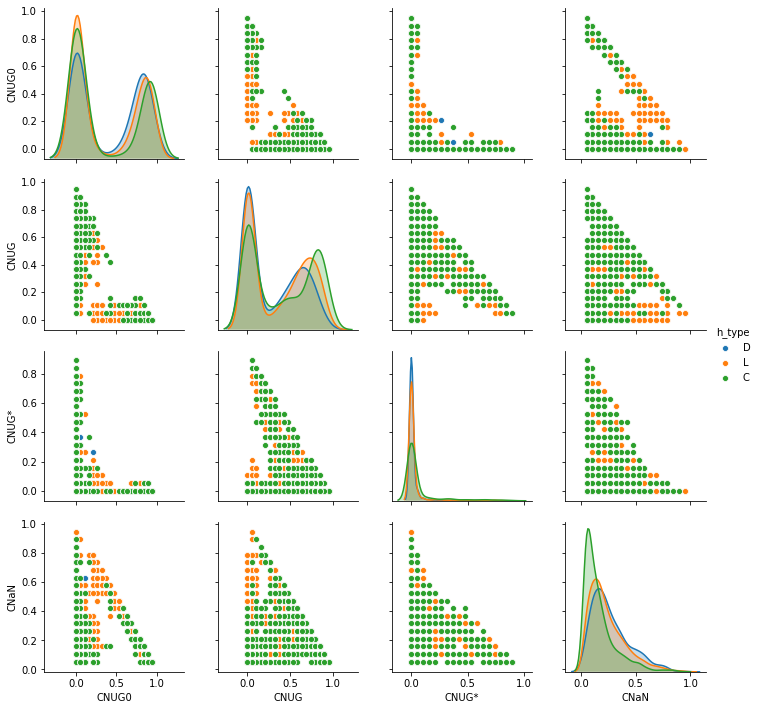

In [99]:
g = sns.pairplot(
    df_train.loc[(df_train["sender"] == "C") & (df_train["h_type"] != "O")], 
    hue="h_type",
    vars=["CNUG0", "CNUG", "CNUG*", "CNaN"]
) 

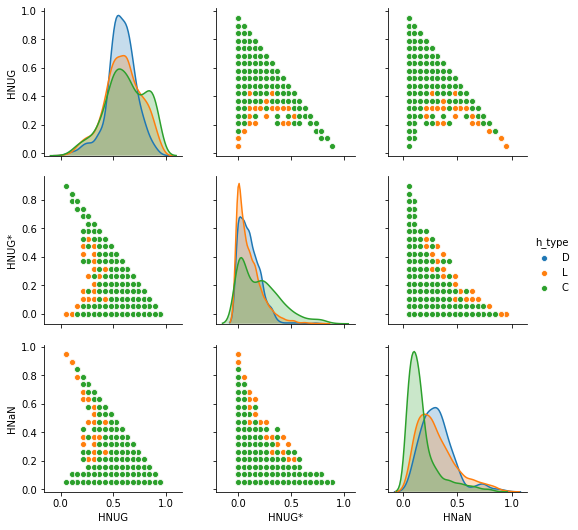

In [102]:
g = sns.pairplot(
    df_train.loc[(df_train["sender"] == "H") & (df_train["h_type"] != "O")], 
    hue="h_type",
    vars=["HNUG", "HNUG*", "HNaN"]
) 

In [107]:
def has_question_mark(row):
    if "?" in row["text"] or "？" in row["text"]:
        return 1
    else:
        return 0

df_train["has_'?'"] = df_train.apply(has_question_mark, axis=1)

In [108]:
df_train

,id,turn,sender,text,h_type,CPAD,CNUG0,CNUG,CNUG*,CNaN,HPAD,HNUG,HNUG*,HNaN,nugget_label,has_'?'
0,3830401296796826,0,C,"中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该...",D,0.0,0.736842,0.052632,0.000000,0.210526,0.0,0.000000,0.000000,0.000000,"[0.0, 0.7368421, 0.05263158, 0.0, 0.21052632]",1
1,3830401296796826,1,H,"您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]；",D,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.473684,0.000000,0.526316,"[0.0, 0.47368422, 0.0, 0.5263158]",0
2,3830772740080373,0,C,"#电信服务怎么了？#广州市白云区太和镇谢家庄二队电信信号差,投诉几年都没人处理.这样的服务态...",D,0.0,0.736842,0.000000,0.000000,0.263158,0.0,0.000000,0.000000,0.000000,"[0.0, 0.7368421, 0.0, 0.0, 0.2631579]",1
3,3830772740080373,1,H,"您好,我是中国电信广东客服小@,已关注到您反映的问题,请详细描述一下您的问题,以便为您处理,...",D,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.526316,0.052632,0.421053,"[0.0, 0.5263158, 0.05263158, 0.42105263]",0
4,3830772740080373,2,C,"看图片就知道,那里连起码的的通信信号都没有,更别说3G上网信号了.一年前还是两年前第一次电话...",D,0.0,0.052632,0.736842,0.000000,0.210526,0.0,0.000000,0.000000,0.000000,"[0.0, 0.05263158, 0.7368421, 0.0, 0.21052632]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15395,4022430433903192,0,C,"@锤子科技客服 QQ时常不能在后台显示,bug?",C,0.0,0.947368,0.000000,0.000000,0.052632,0.0,0.000000,0.000000,0.000000,"[0.0, 0.94736844, 0.0, 0.0, 0.05263158]",1
15396,4022430433903192,1,H,"您好,抱歉给您添麻烦了,请问现在手机系统版本是多少呢？",C,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.894737,0.000000,0.105263,"[0.0, 0.8947368, 0.0, 0.10526316]",1
15397,4022430433903192,2,C,"都自己人别那么客气,系统版本268",C,0.0,0.000000,0.842105,0.000000,0.157895,0.0,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.84210527, 0.0, 0.15789473]",0
15398,4022430433903192,3,H,"收到,我把这个情况反馈给测试工程师进行分析,争取尽快修复",C,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.473684,0.210526,0.315789,"[0.0, 0.47368422, 0.21052632, 0.31578946]",0


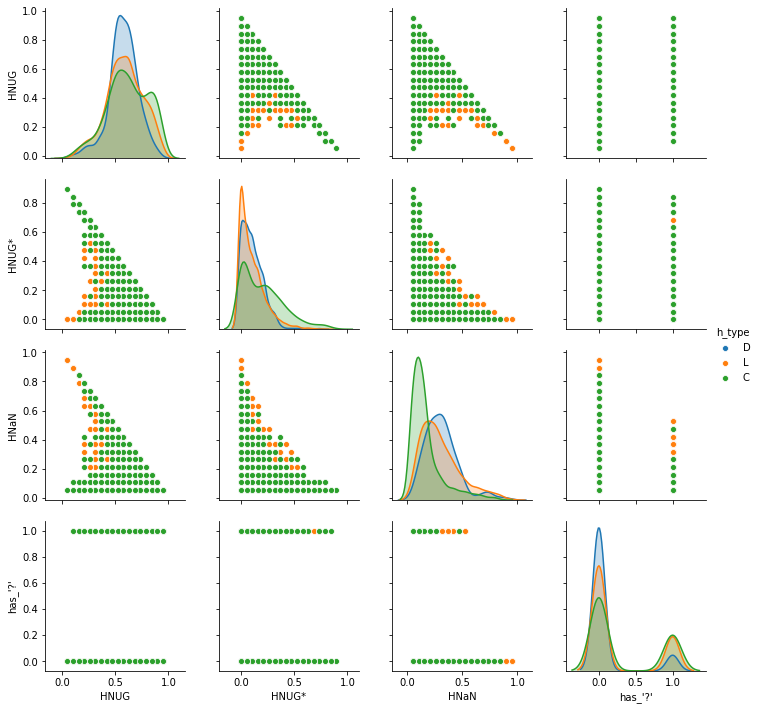

In [111]:
g = sns.pairplot(
    df_train.loc[(df_train["sender"] == "H") & (df_train["h_type"] != "O")], 
    hue="h_type",
    vars=["HNUG", "HNUG*", "HNaN", "has_'?'"]
) 

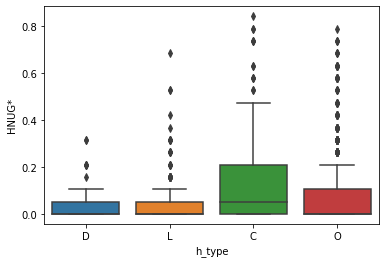

In [132]:
g = sns.boxplot(
    data=df_train.loc[(df_train["sender"] == "H") & (df_train["has_'?'"] == 1)], 
    x="h_type",
    y="HNUG*",
    order=["D", "L", "C", "O"]
) 

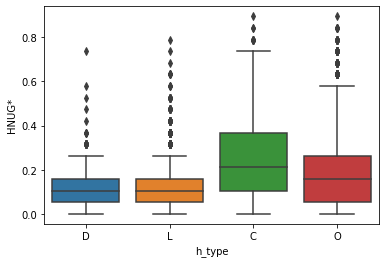

In [133]:
g = sns.boxplot(
    data=df_train.loc[(df_train["sender"] == "H") & (df_train["has_'?'"] == 0)], 
    x="h_type",
    y="HNUG*",
    order=["D", "L", "C", "O"]
) 

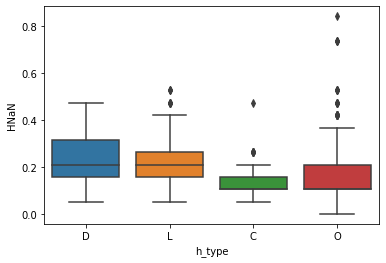

In [134]:
g = sns.boxplot(
    data=df_train.loc[(df_train["sender"] == "H") & (df_train["has_'?'"] == 1)], 
    x="h_type",
    y="HNaN",
    order=["D", "L", "C", "O"]
) 

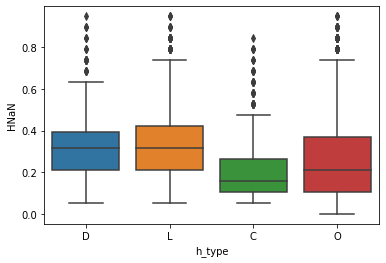

In [135]:
g = sns.boxplot(
    data=df_train.loc[(df_train["sender"] == "H") & (df_train["has_'?'"] == 0)], 
    x="h_type",
    y="HNaN",
    order=["D", "L", "C", "O"]
) 